In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *

display_markdown(
    """
# Components, Data Movement, and Reuse

This tutorial builds off the previous basic CiM array and editing variables
tutorials. In this tutorial, we will explore the CiMLoop architecture
specification, which describes what components are used and how they connect to
move data through the system.

## Reuse

When we consider how components connect, a key concept is *reuse*, or using the
same piece of data multiple times without re-accessing it from backing storage.
We use reuse to reduce the number of accesses to backing storage (*e.g.,* fetch
data from DRAM and reuse it multiple times on-chip) and the number of
activations of circuits (*e.g.,* convert a digital input to analog with a DAC
and reuse that analog input to compute many MAC operations).

Reuse can be set for each component and each tensor (*i.e.,* inputs, outputs,
and weights) independently. We separate reuse into two categories:
*inter-component* and *intra-component* reuse.

### Inter-Component (Spatial) Reuse

Reuse between multiple components, or *spatial* reuse, is when the same piece of
data is used by multiple components in multiple locations. We saw spatial reuse
with the basic CiM array, where inputs are reused between multiple columns and
outputs are reused between multiple rows.

### Intra-Component (Temporal and Coalescing) Reuse

Reuse within a component is when the same piece of data is used multiple times
within a component. First, we define a timestep for a component as any iteration
of a temporal loop that occurs above the level of the component. Note the
**above** part; within a single timestep, temporal loops below the component may
iterate multiple times.

CiMLoop supports three levels of intra-component reuse:

- *Temporal Reuse*, or reuse *between* timesteps, means that a component can
  store values and reuse them across multiple timesteps. For example, a buffer
  can store an input in one cycle and have that input read in subsequent cycles.
  The temporal reuse directive **DOES NOT** affect reuse between loops beneath
  the component.
- *Coalesce*, or reuse *within* a timestep, means that, within a timestep, a
  component can coalesce multiple reads or writes of a value into one read or
  write into backing storage. For example, when an adder sums several values in
  a timestep, it coalesces them into one output. The adder in this case
  coalesces the output, or reuses its output for each addition. Coalescing
  **DOES** affect reuse between loops beneath the component.
- *No-Coalesce*, which implicitly means no temporal reuse as well, means no
  reuse between or within timesteps. For example, if two components generate
  analog outputs and send them to an ADC, the ADC must convert each value and
  write them to backing storage separately. The ADC can neither coalesce nor
  temporally reuse data.

## Reuse Examples

In this tutorial, we'll augment the basic analog CiM macro with additional
components and containers that demonstrate the different types of reuse. We'll
test each of the following components, seeing how they influence the number of
ADC conversions required by the basic analog CiM macro:

- Temporal reuse: An analog storage that stores analog values from one timestep
  to the next.
- Coalesce: An analog adder that sums values from multiple CiM arrays before the
  ADC.
- No-coalesce: An amplifier that receives outputs before the ADC and sends them
  to the ADC without any modification.
"""
)


# Components, Data Movement, and Reuse

This tutorial builds off the previous basic CiM array and editing variables
tutorials. In this tutorial, we will explore the CiMLoop architecture
specification, which describes what components are used and how they connect to
move data through the system.

## Reuse

When we consider how components connect, a key concept is *reuse*, or using the
same piece of data multiple times without re-accessing it from backing storage.
We use reuse to reduce the number of accesses to backing storage (*e.g.,* fetch
data from DRAM and reuse it multiple times on-chip) and the number of
activations of circuits (*e.g.,* convert a digital input to analog with a DAC
and reuse that analog input to compute many MAC operations).

Reuse can be set for each component and each tensor (*i.e.,* inputs, outputs,
and weights) independently. We separate reuse into two categories:
*inter-component* and *intra-component* reuse.

### Inter-Component (Spatial) Reuse

Reuse between multiple components, or *spatial* reuse, is when the same piece of
data is used by multiple components in multiple locations. We saw spatial reuse
with the basic CiM array, where inputs are reused between multiple columns and
outputs are reused between multiple rows.

### Intra-Component (Temporal and Coalescing) Reuse

Reuse within a component is when the same piece of data is used multiple times
within a component. First, we define a timestep for a component as any iteration
of a temporal loop that occurs above the level of the component. Note the
**above** part; within a single timestep, temporal loops below the component may
iterate multiple times.

CiMLoop supports three levels of intra-component reuse:

- *Temporal Reuse*, or reuse *between* timesteps, means that a component can
  store values and reuse them across multiple timesteps. For example, a buffer
  can store an input in one cycle and have that input read in subsequent cycles.
  The temporal reuse directive **DOES NOT** affect reuse between loops beneath
  the component.
- *Coalesce*, or reuse *within* a timestep, means that, within a timestep, a
  component can coalesce multiple reads or writes of a value into one read or
  write into backing storage. For example, when an adder sums several values in
  a timestep, it coalesces them into one output. The adder in this case
  coalesces the output, or reuses its output for each addition. Coalescing
  **DOES** affect reuse between loops beneath the component.
- *No-Coalesce*, which implicitly means no temporal reuse as well, means no
  reuse between or within timesteps. For example, if two components generate
  analog outputs and send them to an ADC, the ADC must convert each value and
  write them to backing storage separately. The ADC can neither coalesce nor
  temporally reuse data.

## Reuse Examples

In this tutorial, we'll augment the basic analog CiM macro with additional
components and containers that demonstrate the different types of reuse. We'll
test each of the following components, seeing how they influence the number of
ADC conversions required by the basic analog CiM macro:

- Temporal reuse: An analog storage that stores analog values from one timestep
  to the next.
- Coalesce: An analog adder that sums values from multiple CiM arrays before the
  ADC.
- No-coalesce: An amplifier that receives outputs before the ADC and sends them
  to the ADC without any modification.


In [2]:
from typing import Any, Dict


ARCH_PATH = "../models/arch/1_macro/basic_analog/arch.yaml"
DEFINES_PATH = "../models/arch/1_macro/basic_analog/arch.yaml"

display_markdown(
    """
### Temporal Reuse: Analog Buffer

We'll start by adding an analog buffer to each column of the CiM array. The
buffer will temporally reuse (store) the analog outputs from the array across
multiple timesteps. After the outputs have been stored for several timesteps,
they will be sent to the ADC.

Below, see the analog buffer specification. We annotate the buffer specification
with a description of each piece.
"""
)


### Temporal Reuse: Analog Buffer

We'll start by adding an analog buffer to each column of the CiM array. The
buffer will temporally reuse (store) the analog outputs from the array across
multiple timesteps. After the outputs have been stored for several timesteps,
they will be sent to the ADC.

Below, see the analog buffer specification. We annotate the buffer specification
with a description of each piece.


In [3]:
STORAGE_CONFIG = """
- !Component
  name: analog_storage
  
  # Set our storage with default values, have it keep outputs, and let it temporally reuse.
  <<<: [*component_defaults, *keep_outputs, *temporal_reuse]
    
  # Dummy_storage components have zero area and energy. In this tutorial, we're not
  # worried about calculating the energy or area of this component.
  subclass: dummy_storage

  # We also set the depth to infinite. Generally, the depth would be limited by the
  # capacity of the component, but we're not concerned with that in this tutorial.
  attributes: {width: 1, depth: INF} # Infinite storage
"""
display_yaml_str(STORAGE_CONFIG)

```yaml

- !Component
  name: analog_storage
  
  # Set our storage with default values, have it keep outputs, and let it temporally reuse.
  <<<: [*component_defaults, *keep_outputs, *temporal_reuse]
    
  # Dummy_storage components have zero area and energy. In this tutorial, we're not
  # worried about calculating the energy or area of this component.
  subclass: dummy_storage

  # We also set the depth to infinite. Generally, the depth would be limited by the
  # capacity of the component, but we're not concerned with that in this tutorial.
  attributes: {width: 1, depth: INF} # Infinite storage
```

In [4]:
display_markdown(
    """
Let's put together a specification using this analog storage component. We'll
be using the basic analog CiM macro from the previous tutorial, which has a placeholder
where the analog storage will go. Below, we create and render a specification. Notice
the placement of the analog storage component in the specification. It's *below* the
ADC in the output movement hierarchy, so temporal reuse from the storage will reduce
the number of ADC conversions.

As a baseline, we'll use the same configuration, but turn off temporal reuse for the
analog storage.

For both configurations, we'll multiply the number of input bits by 

"""
)


Let's put together a specification using this analog storage component. We'll
be using the basic analog CiM macro from the previous tutorial, which has a placeholder
where the analog storage will go. Below, we create and render a specification. Notice
the placement of the analog storage component in the specification. It's *below* the
ADC in the output movement hierarchy, so temporal reuse from the storage will reduce
the number of ADC conversions.

As a baseline, we'll use the same configuration, but turn off temporal reuse for the
analog storage.

For both configurations, we'll multiply the number of input bits by 



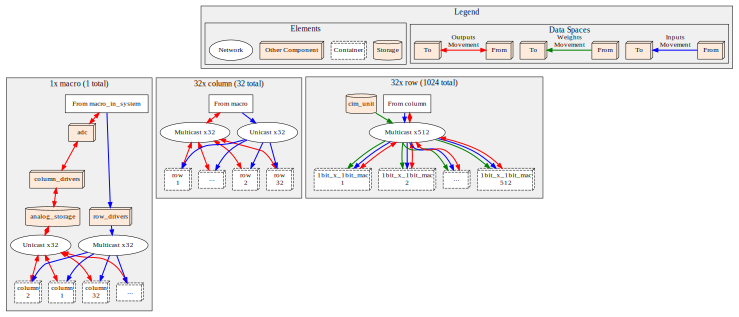

In [5]:
import copy

specs = []

# Grab the spec. Fill in the placeholder with our configuration.
spec = get_spec(
    "basic_analog",
    jinja_parse_data={"ignoreme_placeholder": STORAGE_CONFIG},
    max_utilization=True,  # We're measuring best-case in this tutorial.
)

# Add a temporal loop over input bits beneath the ADC. This loop will generate some
# reuse that may or may not be used by the analog storage.
factors = spec.architecture.find("adc").constraints.temporal.factors_only
factors.add_eq_factor("X", 4, overwrite=True)

# Also increase the number of input bits so we have capacity for the loop we made.
spec.variables["INPUT_BITS"] *= 4

# Create a baseline spec by copying the original spec and turning off temporal reuse.
spec_base = copy.deepcopy(spec)
spec_base.architecture.find("analog_storage").constraints.temporal.no_reuse.append("*")

display_diagram(spec.to_diagram(["macro", "column", "row"]))

In [6]:
display_markdown(
    """
Now we'll run both specifications and compare the mappings side-by-side.
"""
)


Now we'll run both specifications and compare the mappings side-by-side.


In [7]:
def run_get_formatted_print(prefix: str, spec: tl.Specification):
    r = run_mapper(spec)
    result = f"{prefix}\n\n{r.mapping}\n\n"
    result += f'Number of MACs: {r.computes}\n'
    result += f'ADC energy per MAC: {r.per_compute("per_component_energy")["adc"]*1e15:.2f} fJ\n'
    result += f'DAC energy per MAC: {r.per_compute("per_component_energy")["row_drivers"]*1e15:.2f} fJ\n'
    return result

base_results = run_get_formatted_print('No temporal reuse:', spec_base)
storage_results = run_get_formatted_print('With temporal reuse:', spec)

print_side_by_side(base_results, storage_results)

No temporal reuse:                                    |   With temporal reuse:
                                                      |   
dummy_top [ Inputs:1024 (1024) Outputs:256 (256) ]    |   dummy_top [ Inputs:1024 (1024) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                             |   adc [ Outputs:256 (256) ] 
-------------------------                             |   -------------------------
| for X in [0:4)                                      |   | for X in [0:4)
                                                      |   
column_drivers [ Outputs:256 (256) ]                  |   column_drivers [ Outputs:256 (256) ] 
analog_storage [ Outputs:256 (256) ]                  |   analog_storage [ Outputs:256 (256) ] 
row_drivers [ Inputs:256 (256) ]                      |   row_drivers [ Inputs:256 (256) ] 
inter_column_spatial [ ]                              |   inter_column_spatial [ ] 
------------------------                              |   -----------------------

In [8]:
display_markdown(
    """
Notice that the loop nest is identical in both mappings, but in the mapping with
temporal reuse, we got 4x lower ADC energy. This is because, over the `for X in [0:4)`
loop, the analog storage component accumulated and reused the analog output from
the array. Only after all iterations of the loop did the storage send the analog
outputs to the ADC, so the ADC only needed to convert analog outputs once rather
than four times.

Also **note that the temporal loop was above the analog storage** component in the
loop nest. The `no_temporal_reuse` directive only affects reuse for loops above
a component. To affect reuse for loops below a component, we'll need to use the
`no_coalesce` directive.
"""
)


Notice that the loop nest is identical in both mappings, but in the mapping with
temporal reuse, we got 4x lower ADC energy. This is because, over the `for X in [0:4)`
loop, the analog storage component accumulated and reused the analog output from
the array. Only after all iterations of the loop did the storage send the analog
outputs to the ADC, so the ADC only needed to convert analog outputs once rather
than four times.

Also **note that the temporal loop was above the analog storage** component in the
loop nest. The `no_temporal_reuse` directive only affects reuse for loops above
a component. To affect reuse for loops below a component, we'll need to use the
`no_coalesce` directive.


In [9]:
display_markdown(
    """
### Coalesce: Analog Adder
Next, we'll add an analog adder to the macro. Rather than a single CiM array, we'll place two
CiM arrays in parallel and add their outputs together before sending them to the ADC. The adder
will coalesce the outputs of the two arrays into one output.

Below, see the specification for the analog adder. We annotate the adder specification with a
description of each piece. Underneath the adder, we also show a container that groups the two
CiM arrays together.
"""
)


### Coalesce: Analog Adder
Next, we'll add an analog adder to the macro. Rather than a single CiM array, we'll place two
CiM arrays in parallel and add their outputs together before sending them to the ADC. The adder
will coalesce the outputs of the two arrays into one output.

Below, see the specification for the analog adder. We annotate the adder specification with a
description of each piece. Underneath the adder, we also show a container that groups the two
CiM arrays together.


In [10]:
ADDER_CONFIG = """
- !Component
  name: analog_adder
  
  # Set our storage with default values and have it keep outputs. Coalescing
  # is on by default, so we just turn off temporal reuse.
  <<<: [*component_defaults, *keep_outputs, *no_temporal_reuse]

  # Dummy_storage components have zero area and energy. In this tutorial, we're not
  # worried about calculating the energy or area of this component.
  subclass: dummy_storage

  # We also set the depth to infinite. Generally, the depth would be limited by the
  # capacity of the component, but we're not concerned with that in this tutorial.
  attributes: 
    width: 1
    depth: INF # Infinite storage
    # Need an adder for to sum each pair of columns (one column from each array)
    n_instances: column.spatial.get_fanout()
  
- !Container
  name: cim_array
  # Note the no_spatial_reuse declaration. If we did allow spatial reuse, then
  # inputs and outputs would be reused automatically between the two arrays. If this is not
  # supported by the hardware, (such as with this macro where an analog adder is required),
  # then we must explicitly disable spatial reuse.
  <<<: [*container_defaults, *no_spatial_reuse]

  spatial: {meshX: 2} # Two CiM arrays side-by-side
  max_utilization: {spatial: {factors: [C=2]}} # Different input channels between the two arrays
  constraints: {spatial: {factors_only: []}} # We'll fill this in from Python
"""
display_yaml_str(ADDER_CONFIG)

```yaml

- !Component
  name: analog_adder
  
  # Set our storage with default values and have it keep outputs. Coalescing
  # is on by default, so we just turn off temporal reuse.
  <<<: [*component_defaults, *keep_outputs, *no_temporal_reuse]

  # Dummy_storage components have zero area and energy. In this tutorial, we're not
  # worried about calculating the energy or area of this component.
  subclass: dummy_storage

  # We also set the depth to infinite. Generally, the depth would be limited by the
  # capacity of the component, but we're not concerned with that in this tutorial.
  attributes: 
    width: 1
    depth: INF # Infinite storage
    # Need an adder for to sum each pair of columns (one column from each array)
    n_instances: column.spatial.get_fanout()
  
- !Container
  name: cim_array
  # Note the no_spatial_reuse declaration. If we did allow spatial reuse, then
  # inputs and outputs would be reused automatically between the two arrays. If this is not
  # supported by the hardware, (such as with this macro where an analog adder is required),
  # then we must explicitly disable spatial reuse.
  <<<: [*container_defaults, *no_spatial_reuse]

  spatial: {meshX: 2} # Two CiM arrays side-by-side
  max_utilization: {spatial: {factors: [C=2]}} # Different input channels between the two arrays
  constraints: {spatial: {factors_only: []}} # We'll fill this in from Python
```

In [11]:
display_markdown(
    """
Just like before, we'll put together a specification, display it, and run it.
Notice in the diagram that we have another container level, `cim_array`, that
groups the two CiM arrays together. The adder reads the outputs from the two
arrays and coalesces them into one output.

As a baseline, we'll use the same configuration, but turn off coalescing for the
analog adder.
"""
)


Just like before, we'll put together a specification, display it, and run it.
Notice in the diagram that we have another container level, `cim_array`, that
groups the two CiM arrays together. The adder reads the outputs from the two
arrays and coalesces them into one output.

As a baseline, we'll use the same configuration, but turn off coalescing for the
analog adder.


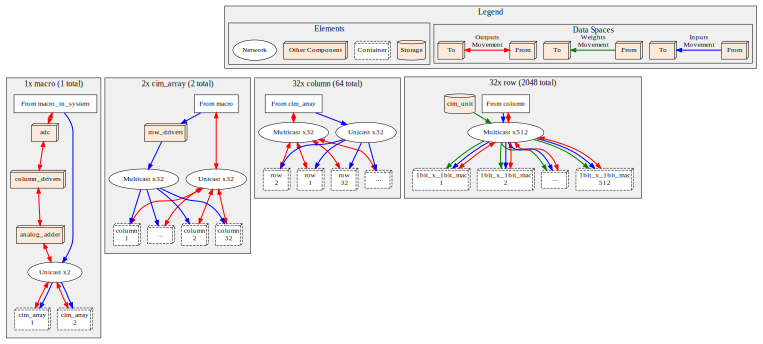

No coalesce:                                        |   With coalesce:
                                                    |   
dummy_top [ Inputs:512 (512) Outputs:256 (256) ]    |   dummy_top [ Inputs:512 (512) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                           |   adc [ Outputs:256 (256) ] 
column_drivers [ Outputs:256 (256) ]                |   column_drivers [ Outputs:256 (256) ] 
analog_adder [ Outputs:256 (256) ]                  |   analog_adder [ Outputs:256 (256) ] 
inter_cim_array_spatial [ ]                         |   inter_cim_array_spatial [ ] 
---------------------------                         |   ---------------------------
| for C in [0:2) (Spatial-X)                        |   | for C in [0:2) (Spatial-X)
                                                    |   
row_drivers [ Inputs:256 (256) ]                    |   row_drivers [ Inputs:256 (256) ] 
inter_column_spatial [ ]                            |   inter_column_spatial [ ] 
--------------

In [12]:
# Grab the spec. Fill in the placeholder with our configuration.
spec = get_spec(
    "basic_analog",
    jinja_parse_data={"ignoreme_placeholder": ADDER_CONFIG},
    max_utilization=True,  # We're measuring best-case in this tutorial.
)
# Add a spatial loop over the two arrays to generate some reuse that may or
# may not be used by the adder. We'll map different input channels to the two
# arrays.
factors = spec.architecture.find("cim_array").constraints.spatial.factors_only
factors.add_eq_factor("C", 2, overwrite=True)

# Create the baseline by copying the spec and turning off coalescing in the adder.
spec_base = copy.deepcopy(spec)
spec_base.architecture.find("analog_adder").constraints.dataspace.no_coalesce.append(
    "*"
)

display_diagram(spec.to_diagram(["macro", "cim_array", "column", "row"]))

base_results = run_get_formatted_print("No coalesce:", spec_base)
coalesce_results = run_get_formatted_print("With coalesce:", spec)
print_side_by_side(base_results, coalesce_results)

In [13]:
display_markdown(
    """
We can see that the loop nest is identical in both mappings, but in the mapping
with coalescing, we got 2x lower ADC energy. This is because the analog adder
component coalesced the outputs of the two arrays into one output, which let the
ADC convert half as many analog outputs.
"""
)


We can see that the loop nest is identical in both mappings, but in the mapping
with coalescing, we got 2x lower ADC energy. This is because the analog adder
component coalesced the outputs of the two arrays into one output, which let the
ADC convert half as many analog outputs.


In [14]:
display_markdown(
    """
As an added comparison, let's compare the non-coalescing adder with having no
adder at all. A non-coalescing adder may be an adder that sums an output with
a constant value, rather than sums multiple outputs together.
"""
)


As an added comparison, let's compare the non-coalescing adder with having no
adder at all. A non-coalescing adder may be an adder that sums an output with
a constant value, rather than sums multiple outputs together.


In [15]:
# Grab the spec. Fill in the placeholder with our configuration.
spec = get_spec(
    "basic_analog",
    jinja_parse_data={"ignoreme_placeholder": ADDER_CONFIG},
    max_utilization=True,  # We're measuring best-case in this tutorial.
)

# Disable coalescing in the adder.
spec.architecture.find("analog_adder").constraints.dataspace.no_coalesce.append("*")

# Add a spatial loop over the two arrays to generate some reuse that may or
# may not be used by the adder. We'll map different input channels to the two
# arrays.
factors = spec.architecture.find("cim_array").constraints.spatial.factors_only
factors.add_eq_factor("C", 2, overwrite=True)

# Create a baseline spec by copying the original spec and removing the adder.
spec_base = copy.deepcopy(spec)
spec_base.architecture.find("analog_adder").enabled = False

base_results = run_get_formatted_print("No adder:", spec_base)
non_coalescing_adder_results = run_get_formatted_print("Non-coalescing adder:", spec)
print_side_by_side(base_results, non_coalescing_adder_results)

No adder:                                           |   Non-coalescing adder:
                                                    |   
dummy_top [ Inputs:512 (512) Outputs:256 (256) ]    |   dummy_top [ Inputs:512 (512) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                           |   adc [ Outputs:256 (256) ] 
column_drivers [ Outputs:256 (256) ]                |   column_drivers [ Outputs:256 (256) ] 
                                                    |   analog_adder [ Outputs:256 (256) ] 
inter_cim_array_spatial [ ]                         |   inter_cim_array_spatial [ ] 
---------------------------                         |   ---------------------------
| for C in [0:2) (Spatial-X)                        |   | for C in [0:2) (Spatial-X)
                                                    |   
row_drivers [ Inputs:256 (256) ]                    |   row_drivers [ Inputs:256 (256) ] 
inter_column_spatial [ ]                            |   inter_column_spatial [ ] 
-------

In [16]:
display_markdown(
    """
We can see that the non-coalescing adder did not affect ADC energy. In fact, from a
reuse perspective, it was the same as having no adder at all. To see why, let's look
at no-coalesce components.
"""
)


We can see that the non-coalescing adder did not affect ADC energy. In fact, from a
reuse perspective, it was the same as having no adder at all. To see why, let's look
at no-coalesce components.


In [17]:
display_markdown(
    """
### No-Coalesce: Analog Amplifier

Finally, we'll add an analog amplifier to the macro. The amplifier will receive
the analog outputs from the array and send them to the ADC without any modification.
The amplifier will not coalesce or temporally reuse the analog outputs.

To create some reuse in the mapping, we'll again create a temporal loop beneath the
ADC and we will also create two side-by-side CiM arrays whose outputs will be summed.
"""
)


### No-Coalesce: Analog Amplifier

Finally, we'll add an analog amplifier to the macro. The amplifier will receive
the analog outputs from the array and send them to the ADC without any modification.
The amplifier will not coalesce or temporally reuse the analog outputs.

To create some reuse in the mapping, we'll again create a temporal loop beneath the
ADC and we will also create two side-by-side CiM arrays whose outputs will be summed.


In [18]:
AMPLIFIER_CONFIG = """
- !Component
  name: analog_amplifier
  
  # Set our storage with default values, keep outputs, and disable all reuse.
  <<<: [*component_defaults, *keep_outputs, *no_coalesce]

  # Dummy_storage components have zero area and energy. In this tutorial, we're not
  # worried about calculating the energy or area of this component.
  subclass: dummy_storage

  # We also set the depth to infinite. Generally, the depth would be limited by the
  # capacity of the component, but we're not concerned with that in this tutorial.
  attributes: 
    width: 1
    depth: INF # Infinite storage
    # Need an amplifier for each column
    n_instances: column.spatial.get_fanout()

- !Container
  name: cim_array
  # Note the no_spatial_reuse declaration. If we did allow spatial reuse, then
  # inputs and outputs would be reused automatically between the two arrays. If this is not
  # supported by the hardware, (such as with this macro where an analog adder is required),
  # then we must explicitly disable spatial reuse.
  <<<: [*container_defaults, *no_spatial_reuse]

  spatial: {meshX: 2} # Two CiM arrays side-by-side
  max_utilization: {spatial: {factors: [C=2]}} # Different input channels between the two arrays
  constraints: {spatial: {factors_only: []}} # We'll fill this in from Python
"""
display_yaml_str(AMPLIFIER_CONFIG)

```yaml

- !Component
  name: analog_amplifier
  
  # Set our storage with default values, keep outputs, and disable all reuse.
  <<<: [*component_defaults, *keep_outputs, *no_coalesce]

  # Dummy_storage components have zero area and energy. In this tutorial, we're not
  # worried about calculating the energy or area of this component.
  subclass: dummy_storage

  # We also set the depth to infinite. Generally, the depth would be limited by the
  # capacity of the component, but we're not concerned with that in this tutorial.
  attributes: 
    width: 1
    depth: INF # Infinite storage
    # Need an amplifier for each column
    n_instances: column.spatial.get_fanout()

- !Container
  name: cim_array
  # Note the no_spatial_reuse declaration. If we did allow spatial reuse, then
  # inputs and outputs would be reused automatically between the two arrays. If this is not
  # supported by the hardware, (such as with this macro where an analog adder is required),
  # then we must explicitly disable spatial reuse.
  <<<: [*container_defaults, *no_spatial_reuse]

  spatial: {meshX: 2} # Two CiM arrays side-by-side
  max_utilization: {spatial: {factors: [C=2]}} # Different input channels between the two arrays
  constraints: {spatial: {factors_only: []}} # We'll fill this in from Python
```

In [19]:
display_markdown(
    """
Now we'll put together a specification, display it, and run it. As a baseline,
we'll use the same configuration but with no amplifier.
"""
)


Now we'll put together a specification, display it, and run it. As a baseline,
we'll use the same configuration but with no amplifier.


In [20]:
specs = []
# Grab the spec. Fill in the placeholder with our configuration.
spec = get_spec(
    "basic_analog",
    jinja_parse_data={"ignoreme_placeholder": AMPLIFIER_CONFIG},
    max_utilization=True,  # We're measuring best-case in this tutorial.
)

# Add a spatial loop over the two arrays to generate some reuse that may or
# may not be used by the adder. We'll map different input channels to the two
# arrays.
factors = spec.architecture.find("cim_array").constraints.spatial.factors_only
factors.add_eq_factor("C", 2, overwrite=True)

# Add a temporal loop beneath the ADC to generate some reuse that may or may not
# be used by the amplifier.
factors = spec.architecture.find("adc").constraints.temporal.factors_only
factors.add_eq_factor("X", 4, overwrite=True)

# Also increase the number of input bits so we have capacity for the loop we made.
spec.variables["INPUT_BITS"] *= 4

# Create a baseline spec by copying the original spec and removing the amplifier.
spec_base = copy.deepcopy(spec)
spec_base.architecture.find("analog_amplifier").enabled = False

base_results = run_get_formatted_print("No amplifier:", spec_base)
amplfier_results = run_get_formatted_print("Amplifier:", spec)
print_side_by_side(base_results, amplfier_results)

No amplifier:                                         |   Amplifier:
                                                      |   
dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ]    |   dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                             |   adc [ Outputs:256 (256) ] 
-------------------------                             |   -------------------------
| for X in [0:4)                                      |   | for X in [0:4)
                                                      |   
column_drivers [ Outputs:256 (256) ]                  |   column_drivers [ Outputs:256 (256) ] 
                                                      |   analog_amplifier [ Outputs:256 (256) ] 
inter_cim_array_spatial [ ]                           |   inter_cim_array_spatial [ ] 
---------------------------                           |   ---------------------------
|   for C in [0:2) (Spatial-X)                        |   |   for C in [0:2) (Spatial-X)
   

In [21]:
display_markdown(
    """
We can see that the loop nest is identical for both mappings, and ADC energy is
the same as well! If a component can't coalesce, then it doesn't admit any reuse
for loops above or beneath itself. For this reason, it does not affect the
number of accesses to other components

Generally, we'll use `no_coalesce` for components that propagate or process data
but don't affect reuse. For example, dedicated circuits such as ADCs and DACs
generally fall into this category. As another example, we'll add an amplifier
component to the macro.
"""
)


We can see that the loop nest is identical for both mappings, and ADC energy is
the same as well! If a component can't coalesce, then it doesn't admit any reuse
for loops above or beneath itself. For this reason, it does not affect the
number of accesses to other components

Generally, we'll use `no_coalesce` for components that propagate or process data
but don't affect reuse. For example, dedicated circuits such as ADCs and DACs
generally fall into this category. As another example, we'll add an amplifier
component to the macro.


In [22]:
display_markdown(
    """
## Side-By-Side-By-Side Comparison and Review

Finally, let's compare all levels of reuse with a single component. We'll use
our amplifier and give it the ability to temporally reuse or coalesce. We compare
four configurations:

- No amplifier
- Amplifier with no coalescing or temporal reuse
- Amplifier with coalescing
- Amplifier with temporal reuse (implies coalescing as well)

Like we did before, we'll use a temporal loop beneath the ADC and two side-by-side
CiM arrays to generate some reuse that may or may not be used by the amplifier.
"""
)


## Side-By-Side-By-Side Comparison and Review

Finally, let's compare all levels of reuse with a single component. We'll use
our amplifier and give it the ability to temporally reuse or coalesce. We compare
four configurations:

- No amplifier
- Amplifier with no coalescing or temporal reuse
- Amplifier with coalescing
- Amplifier with temporal reuse (implies coalescing as well)

Like we did before, we'll use a temporal loop beneath the ADC and two side-by-side
CiM arrays to generate some reuse that may or may not be used by the amplifier.


In [23]:
spec_base = copy.deepcopy(spec)
spec_base.architecture.find("analog_amplifier").enabled = False

spec_no_coalesce = copy.deepcopy(spec)
spec_no_coalesce.architecture.find(
    "analog_amplifier"
).constraints.dataspace.no_coalesce.append("*")

spec_coalesce = copy.deepcopy(spec)
spec_coalesce.architecture.find(
    "analog_amplifier"
).constraints.dataspace.no_coalesce.clear()
spec_coalesce.architecture.find(
    "analog_amplifier"
).constraints.temporal.no_reuse.append("*")

spec_temporal_reuse = copy.deepcopy(spec)
spec_temporal_reuse.architecture.find(
    "analog_amplifier"
).constraints.dataspace.no_coalesce.clear()
spec_temporal_reuse.architecture.find(
    "analog_amplifier"
).constraints.temporal.no_reuse.clear()

base_results = run_get_formatted_print("No amplifier:", spec_base)
no_coalesce_results = run_get_formatted_print("No coalesce:", spec_no_coalesce)
coalesce_results = run_get_formatted_print(
    "Coalesce, No Temporal Reuse:", spec_coalesce
)
temporal_reuse_results = run_get_formatted_print(
    "Coalesce and Temporal reuse:", spec_temporal_reuse
)

In [24]:
display_markdown(
    """
Let's compare the ADC energy for the base result and each of the three configurations.
"""
)


Let's compare the ADC energy for the base result and each of the three configurations.


In [25]:
print_side_by_side(base_results, no_coalesce_results)

No amplifier:                                         |   No coalesce:
                                                      |   
dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ]    |   dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                             |   adc [ Outputs:256 (256) ] 
-------------------------                             |   -------------------------
| for X in [0:4)                                      |   | for X in [0:4)
                                                      |   
column_drivers [ Outputs:256 (256) ]                  |   column_drivers [ Outputs:256 (256) ] 
                                                      |   analog_amplifier [ Outputs:256 (256) ] 
inter_cim_array_spatial [ ]                           |   inter_cim_array_spatial [ ] 
---------------------------                           |   ---------------------------
|   for C in [0:2) (Spatial-X)                        |   |   for C in [0:2) (Spatial-X)
 

In [26]:
print_side_by_side(base_results, coalesce_results)

No amplifier:                                         |   Coalesce, No Temporal Reuse:
                                                      |   
dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ]    |   dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                             |   adc [ Outputs:256 (256) ] 
-------------------------                             |   -------------------------
| for X in [0:4)                                      |   | for X in [0:4)
                                                      |   
column_drivers [ Outputs:256 (256) ]                  |   column_drivers [ Outputs:256 (256) ] 
                                                      |   analog_amplifier [ Outputs:256 (256) ] 
inter_cim_array_spatial [ ]                           |   inter_cim_array_spatial [ ] 
---------------------------                           |   ---------------------------
|   for C in [0:2) (Spatial-X)                        |   |   for C in [0:

In [27]:
print_side_by_side(base_results, temporal_reuse_results)

No amplifier:                                         |   Coalesce and Temporal reuse:
                                                      |   
dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ]    |   dummy_top [ Inputs:2048 (2048) Outputs:256 (256) ] 
adc [ Outputs:256 (256) ]                             |   adc [ Outputs:256 (256) ] 
-------------------------                             |   -------------------------
| for X in [0:4)                                      |   | for X in [0:4)
                                                      |   
column_drivers [ Outputs:256 (256) ]                  |   column_drivers [ Outputs:256 (256) ] 
                                                      |   analog_amplifier [ Outputs:256 (256) ] 
inter_cim_array_spatial [ ]                           |   inter_cim_array_spatial [ ] 
---------------------------                           |   ---------------------------
|   for C in [0:2) (Spatial-X)                        |   |   for C in [0:

In [28]:
display_markdown(
    """
We can summarize the results as follows:

- Reuse is identical between a non-coalescing amplifier and no amplifier at all. Non-coalescing
  components do not affect reuse, but they still affect the area/energy/latency of the system.
  An amplifier that doesn't coalesce is effectively a pass-through.
- Coalescing the amplifier halves the number of ADC conversions, which halves the ADC energy.
  This is because coalescing affected the loop *below* the amplifier, which was the spatial loop
  `for C in [0:2)`. Coalescing is useful for components that can sum, combine, or reorganize data.
- Temporal reuse in the amplifier divided the number of ADC conversions by eight because it affected
  both the loop *above* the amplifier, which was the temporal loop `for X in [0:4)`, and the loop
  below the amplifier, the spatial loop `for C in [0:2)`. Temporal reuse is useful for components
  that can store and reuse data across multiple timesteps.
  
In this tutorial, we've explored the different types of reuse in CiMLoop and how they affect the
number of accesses to backing storage. We can now use these different types of reuse to model
different CiM macros.
"""
)


We can summarize the results as follows:

- Reuse is identical between a non-coalescing amplifier and no amplifier at all. Non-coalescing
  components do not affect reuse, but they still affect the area/energy/latency of the system.
  An amplifier that doesn't coalesce is effectively a pass-through.
- Coalescing the amplifier halves the number of ADC conversions, which halves the ADC energy.
  This is because coalescing affected the loop *below* the amplifier, which was the spatial loop
  `for C in [0:2)`. Coalescing is useful for components that can sum, combine, or reorganize data.
- Temporal reuse in the amplifier divided the number of ADC conversions by eight because it affected
  both the loop *above* the amplifier, which was the temporal loop `for X in [0:4)`, and the loop
  below the amplifier, the spatial loop `for C in [0:2)`. Temporal reuse is useful for components
  that can store and reuse data across multiple timesteps.
  
In this tutorial, we've explored the different types of reuse in CiMLoop and how they affect the
number of accesses to backing storage. We can now use these different types of reuse to model
different CiM macros.


In [31]:
display_markdown(
'''
## Banked Components and `n_instances`

You may have noticed something interesting with the analog amplifier;
specifically, each column in the memory array had its own amplifier, and yet in
the hierarchy, we specified only one amplifier component. Furthermore, this
component was specified above the memory array in the hierarchy. Isn't it connected
to a column?

This leads to a key concept im CiMLoop: *banked components*. A component is
*banked* when it has multiple instances that are used in parallel and treated as
a single component. For example, can express the analog amplifier in two ways:

- Non-banked: We specify an amplifier for each column in the memory array. We'd
  place the amplifier in the column container and set n_instances to 1.
- Banked: We could place the analog amplifier at a higher level in the
  hierarchy and set n_instances to the number of columns in the memory array.
  This is what we did in this tutorial.
  
Banking is useful for realizing non-hierarchical components in a hierarchical
fashion. For example, we bank the row drivers for all rows into a single
component, even though there may be a distinct driver for each row of the array.
We also bank ADCs and we bank column drivers, even though both may be used in
each column of the array. In this tutorial, we banked the analog adder and
analog amplifier components.

When we bank components, we often set the `n_instances` attribute. This is a
special attribute that replicates the component `n_instances` times and treats
them as a single component. This will increase the area and leakage energy of
the component by a factor of `n_instances`. Note that `n_instances` does not
affect dynamic energy because it does not change the number of accesses to
components (i.e., if you read 10 values from 1 buffer, you incur the same number
of reads as reading 1 value from 10 different buffers).

A limitation of banking is that when components are banked, statistics such as
their storage capacity and bandwidth are shared across all instances. If
per-instance accesses are needed, then the component should not be banked. If
these are not needed, then banking can be a useful way to create a hierarchical
specification.

Check out the example macros for examples of banking. Each component where
`n_instances` is set is banked. Furthermore, components such as the ADC, row
drivers, and column drivers are banked automatically in the component `.yaml`
files or in the plug-ins.
'''
)


## Banked Components and `n_instances`

You may have noticed something interesting with the analog amplifier;
specifically, each column in the memory array had its own amplifier, and yet in
the hierarchy, we specified only one amplifier component. Furthermore, this
component was specified above the memory array in the hierarchy. Isn't it connected
to a column?

This leads to a key concept im CiMLoop: *banked components*. A component is
*banked* when it has multiple instances that are used in parallel and treated as
a single component. For example, can express the analog amplifier in two ways:

- Non-banked: We specify an amplifier for each column in the memory array. We'd
  place the amplifier in the column container and set n_instances to 1.
- Banked: We could place the analog amplifier at a higher level in the
  hierarchy and set n_instances to the number of columns in the memory array.
  This is what we did in this tutorial.
  
Banking is useful for realizing non-hierarchical components in a hierarchical
fashion. For example, we bank the row drivers for all rows into a single
component, even though there may be a distinct driver for each row of the array.
We also bank ADCs and we bank column drivers, even though both may be used in
each column of the array. In this tutorial, we banked the analog adder and
analog amplifier components.

When we bank components, we often set the `n_instances` attribute. This is a
special attribute which replicates the component `n_instances` times and treats
them as a single component. This will increase the area and leakage energy of
the component by a factor of `n_instances`. Note that `n_instances` does not
affect dynamic energy because it does not change the number of accesses to
components (i.e., if you read 10 values from 1 buffer, you incur the same number
of reads as reading 1 value from 10 different buffers).

A limitation of banking is that when components are banked, statistics such as
their storage capacity and bandwidth are shared across all instances. If
per-instance accesses are needed, then the component should not be banked. If
these are not needed, then banking can be a useful way to create a hierarchical
specification.

For an example that uses banking extensively, see the `albireo_isca_2021` macro
example. This macro uses photonic computing, and has multiple points where a
bank of parallel components process data (note that every component with
`n_instances` set is banked in this macro).
